Using TensorFlow backend.


Loading data from "./data/udacity/driving_log.csv"...
./data/udacity/
Loading data from "./data/t2_forward/driving_log.csv"...
./data/t2_forward/
Loading data from "./data/t2_backwards/driving_log.csv"...
./data/t2_backwards/
---------------
Printing a sample line:
	center: IMG/center_2016_12_01_13_30_48_287.jpg
	left:  IMG/left_2016_12_01_13_30_48_287.jpg
	right:  IMG/right_2016_12_01_13_30_48_287.jpg
	angle: 0
	throttle: 0
	break: 0
	speed: 22.14829
---------------
Number of images is 13271.
Number of filenames is 39813.
Number of labels is 39813.
Shape of X after cleaning is (21634, 160, 320, 3)
Number of y after cleaning is 21634



<ipython-input-1-8f1e987b80b7>:386: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_training_data_from_memory" failed type inference due to: Untyped global name 'shuffle': cannot determine Numba type of <class 'function'>

File "<ipython-input-1-8f1e987b80b7>", line 396:
def generate_training_data_from_memory(data_orig, labels_orig, batch_size=256, validation_flag=False, debug=False):
    <source elided>
    labels = np.copy(labels_orig)
    data, labels = shuffle(data, labels)
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/compiler.py:725: NumbaWarning: Function "generate_training_data_from_memory" was compiled in object mode without forceobj=True.

File "<ipython-input-1-8f1e987b80b7>", line 387:
@jit
def generate_training_data_from_memory(data_orig, labels_orig, batch_size=256, validation_flag=False, debug=False):
^

  self.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/compiler.py:734: NumbaDeprec

# of labels: 21634
Batch size: 1024
# valid samples: 8
# per epoch: 33


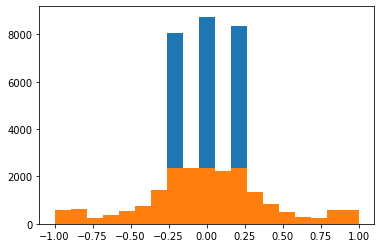

Making model:
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
dropout

In [ ]:
# global parameters
angle_correction = 0.2
validation_split = 0.2
batch_size = 1024
model_debug = False # makes a simple model for debug
udacity_data = False
loading_model = False
debug_cleaning = False
augment_data = False

if loading_model:
    model_name = 'model.h5' # trained for 20 epochs

# imports
import os, platform, glob, csv, cv2
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

import sys
from numba import jit
device_name = sys.argv[1]  # Choose device from cmd line. Options: gpu or cpu
if device_name == "gpu":
    device_name = "/gpu:0"
else:
    device_name = "/cpu:0"


def print_line(line):
    '''
    prints a sample line from csv
    for debugging purposes
    '''
    print("-"*15)
    print("Printing a sample line:")
    for n, e in zip(lines_headers, line):
        print("\t{}: {}".format(n, e))
    print("-"*15)

#@jit
def read_sim_logs(csv_paths):
    """
    Reads each `.csv` file and stores the image file paths and measurement values to a list of dictionaries.
    :param csv_paths: list of file paths to CSV files created by the simulator.
    :return: list of dictionaries containing image files and measurements from the simulator at each sample.
    """
    log_file_name = 'driving_log.csv'
    
    lines = []
    labels = []
    filenames = []
    if not isinstance(csv_paths, list):
        csv_paths = [csv_paths]
    for i_path, path in enumerate(csv_paths):
        csv_file_path = os.path.join(path, log_file_name)
        print('Loading data from "{}"...'.format(csv_file_path))
        img_path = path +"IMG/"
        print(path)
        with open(csv_file_path, 'rt') as f:
            reader = csv.reader(f, delimiter=',')
            for line in reader:
                if line is None:
                    # empty line
                    continue
                lines.append(line)
                
                center_image_path = os.path.join(img_path,  line[0].split('/')[-1])
                left_image_path = os.path.join(img_path,  line[1].split('/')[-1])
                right_image_path = os.path.join(img_path,  line[2].split('/')[-1])

                center_angle = float(line[3])
                left_angle = center_angle + angle_correction
                right_angle = center_angle - angle_correction

                labels.extend([center_angle, left_angle, right_angle])
                filenames.extend([center_image_path, left_image_path, right_image_path])
    return lines, filenames, labels


def get_image(log_path, path_to_imgs):
    '''
    this routine returns an image by appending filename from log_path
    to the images directory from path_to_imgs
    '''
    image_path = get_image_path(log_path, path_to_imgs)
    # cv2 reads to BGR
    return cv2.imread(image_path)

def normalize_pixels(pixel_value):
    '''
    normalizes pixel values to have zero mean and SD of 1
    '''
    result = pixel_value / 255.0 - 0.5
    return result


    
def clean_data(data, labels, depth=0, n_bins=20, debug=False):
    '''
    this routine removes data in overrepresented bins in a histogram of steering angles
    depth paratemeter tells what is the target number of examples in each bin
    depth of 0 means all bins should have at most as many elements as the second largest bin
    depth of 1 means all bins should have at most as many elements as the third largest bin etc.
    returns modified images and labels
    ---
    superceded by clean_filenames_labels which is a generator and works faster
    by not storing actual data in memory
    '''
    (counts, bins, _) = plt.hist(labels, bins=np.linspace(-1,1,n_bins), label='hst')
    
    target_size = int(sorted(counts, reverse=True)[1 + depth])
    if debug: print("Target bin count:", target_size)
    if debug: print("-"*15)
    
    all_indices_to_remove = []
    
    for pos, count in enumerate(counts):
        if debug: print("Position:", pos)
        if debug: print("Count:", count)
        if count > target_size:
            if debug: print("Not alright, need to remove some.")
            lower_bound = bins[pos]
            upper_bound = bins[pos + 1]
            if debug: print("Lower:", lower_bound)
            if debug: print("Upper:", upper_bound)
            all_indices = np.where((labels > lower_bound) & (labels < upper_bound))[0]
            n_to_remove = len(all_indices) - target_size
            if debug: print("Need to remove:", n_to_remove)
            indices_to_remove = np.random.choice(all_indices, size = n_to_remove, replace=False)
            if debug: print("All indices before:", len(all_indices_to_remove))
            all_indices_to_remove.extend(indices_to_remove)
            if debug: print("All indices after:", len(all_indices_to_remove))
        else:
            if debug: print("Alright, alright, alright!")
            continue
        if debug: print("-"*15)

    labels_new = np.delete(labels, all_indices_to_remove, axis=0)
    data_new = np.delete(data, all_indices_to_remove, axis=0)
    return data_new, labels_new

def clean_filenames_labels(filenames, labels, depth=0, n_bins=20, debug=False):
    '''
    this routine removes filenames and labels in overrepresented bins in a histogram of steering angles
    depth paratemeter tells what is the target number of examples in each bin
    depth of 0 means all bins should have at most as many elements as the second largest bin
    depth of 1 means all bins should have at most as many elements as the third largest bin etc.
    returns modified filenames and labels
    
    '''
    if debug: print("*"*30) 
    if debug: print("clean_filenames_labels, befor:{}".format(len(labels)))
    
    (counts, bins, _) = plt.hist(labels, bins=np.linspace(-1,1,n_bins), label='hst')
   
    
    target_size = int(sorted(counts, reverse=True)[1 + depth])
    if debug: print("Target bin count:", target_size)
    if debug: print("-"*15)
    
    all_indices_to_remove = []
    
    for pos, count in enumerate(counts):
        if debug: print("Position:", pos)
        if debug: print("Count:", count)
        if count > target_size:
            if debug: print("Not alright, need to remove some.")
            lower_bound = bins[pos]
            upper_bound = bins[pos + 1]
            if debug: print("Lower:", lower_bound)
            if debug: print("Upper:", upper_bound)
            all_indices = np.where((labels > lower_bound) & (labels < upper_bound))[0]
            n_to_remove = len(all_indices) - target_size
            if debug: print("Need to remove:", n_to_remove)
            indices_to_remove = np.random.choice(all_indices, size = n_to_remove, replace=False)
            if debug: print("All indices before:", len(all_indices_to_remove))
            all_indices_to_remove.extend(indices_to_remove)
            if debug: print("All indices after:", len(all_indices_to_remove))
        else:
            if debug: print("[McConaughey voice] Alright, alright, alright!")
            continue
        if debug: print("-"*15)

    labels_new = np.delete(labels, all_indices_to_remove, axis=0)
    filenames_new = np.delete(filenames, all_indices_to_remove, axis=0)
    
    if debug: print("*"*30) 
    if debug: print("clean_filenames_labels, After:{}".format(len(labels_new)))
    return filenames_new, labels_new 

def augment_filenames_labels(filenames, labels, depth=0, n_bins=20, debug=False):
    '''
    this routine removes filenames and labels in overrepresented bins in a histogram of steering angles
    depth paratemeter tells what is the target number of examples in each bin
    depth of 0 means all bins should have at most as many elements as the second largest bin
    depth of 1 means all bins should have at most as many elements as the third largest bin etc.
    returns modified filenames and labels
    
    '''
    if debug: print("*"*30) 
    if debug: print("augment_filenames_labels, befor:{}".format(len(labels)))
        
    (counts, bins, _) = plt.hist(labels, bins=np.linspace(-1,1,n_bins), label='hst')
    plt.show()
    
    target_size = int(sorted(counts, reverse=True)[1 + depth])
    if debug: print("Target bin count:", target_size)
    if debug: print("-"*15)
    
    add_filenames = []
    add_lables = []
    
    for pos, count in enumerate(counts):
        if debug: print("Position:", pos)
        if debug: print("Count:", count)
        if count > target_size:
            if debug: print("Alright, alright, alright!")
            continue
        else:
            if debug: print("Not alright, need to augment some.")
            lower_bound = bins[pos]
            upper_bound = bins[pos + 1]
            if debug: print("Lower:", lower_bound)
            if debug: print("Upper:", upper_bound)
            all_indices = np.where((labels > lower_bound) & (labels < upper_bound))[0]
            n_to_add = int(target_size - count)
            if debug: print("n_to_add:", n_to_add)
            
            
            for i in range(n_to_add):
                choice = int(np.random.choice(all_indices,1))
                add_filenames.append(filenames[choice])
                add_lables.append(labels[choice])
            
        if debug: print("-"*15)
    
    print("add_filenames:{} num:{}".format(add_filenames[0], len(add_filenames)))
    print("add_lables:{} num:{}".format(add_lables[0], len(add_lables)))
          
            
    filenames.extend(add_filenames);
    labels.extend(add_lables);
    
    
    if debug: print("*"*30) 
    if debug: print("augment_filenames_labels, After:{}".format(len(labels)))
    return filenames, labels


def make_clean_data(filenames, labels):
    '''
    returns an array of filtered images stored in memory
    to be fed into custom data generator
    '''
    X = []
    for f in filenames:
        image = cv2.imread(f)
        X.append(image)
    X = np.array(X)
    print("Shape of X after cleaning is", X.shape)
    print("Number of y after cleaning is", len(labels))
    print()
    
    return X, labels


def make_model(act='elu', d=0.5, debug=False):
    '''
    nVidia end-to-end driving model
    1) custom activation and dropout
    2) custom preprocessing layers
    '''
    model = Sequential()
    model.add(Cropping2D(cropping=((65, 25), (0, 0)), input_shape=(160, 320, 3)))
    model.add(Lambda(normalize_pixels, output_shape=(70, 320, 3)))
    if debug:
        model.add(Flatten())
        model.add(Dense(1))
        return model
    model.add(Conv2D(24, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(64, (3,3), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(64, (3,3), activation=act))
    model.add(Dropout(d))
    model.add(Flatten())
    model.add(Dense(100, activation=act))
    model.add(Dropout(d))
    model.add(Dense(50, activation=act))
    model.add(Dropout(d))
    model.add(Dense(10, activation=act))
    model.add(Dense(1))
    return model


def preprocess_image(image):
    # Gaussian blur
    image = cv2.GaussianBlur(image, (3,3), 0)
    # Convert to YUV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image


def brighten_image(image):
    '''
    performs random brightening / darkening of the image
    in order to generalize driving in different lighting
    conditions
    '''
    value = np.random.randint(-28, 28)
    # the mask prevents values from being outside (0,255)
    if value > 0:
        mask = (image[:,:,0] + value) > 255 
    if value <= 0:
        mask = (image[:,:,0] + value) < 0
    image[:,:,0] += np.where(mask, 0, value)
    return image


def shadow_image(image):
    '''
    random shadow to make the model drive on
    roads with random shadows
    shadow is random region:
        - full height
        - left or right portion of image
    shadow area will be 20%-40% darker
    '''
    height, width = image.shape[0:2]
    # random horizontal line
    mid = np.random.randint(0, width)
    # image is in YUV
    # factor darkens 1st channel (brightness)
    factor = np.random.uniform(0.6,0.8)
    # random shadow on the left or on the right of image
    if np.random.rand() > .5:
        image[:, 0:mid, 0] *= factor
    else:
        image[:, mid:width, 0] *= factor
    return image


def shift_horizon(image):
    '''
    randomly shift horizon to simulate
    driving in areas with hills
    this transform will move horizon
    vertically  up or down 
    for up to 1/8 of height
    '''
    height, width = image.shape[0:2]
    # horizon value (calculated empirically)
    horizon = 0.4 * height
    v_shift = np.random.randint(- height / 8, height / 8)
    pts1 = np.float32([[0, horizon], [width, horizon], [0, height], [width, height]])
    pts2 = np.float32([[0, horizon + v_shift], [width, horizon + v_shift], [0, height], [width, height]])
    transform_matrix = cv2.getPerspectiveTransform(pts1, pts2)
    new_img = cv2.warpPerspective(image, transform_matrix, (width, height) , borderMode=cv2.BORDER_REPLICATE)
    return image

def augment_image(image, label, proba=0.5):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = image.astype(float)
    # 1) randomly flip image horizontally and reverse label
    if np.random.rand() > proba:
        new_img = cv2.flip(new_img, 1)
        label = -label
    # 2) random brightness
    new_img = brighten_image(new_img)
    # 3) random shadow
    new_img = shadow_image(new_img)
    # 4) random horizon shift
    new_img = shift_horizon(new_img)
    return new_img.astype(np.uint8), label

@jit
def generate_training_data_from_memory(data_orig, labels_orig, batch_size=256, validation_flag=False, debug=False):
    '''
    this is a generator that yields data from numpy array in memory
    and performs preprocessing and augmentation on the fly,
    without storing all augmented data in memory
    if validation_flag is True, no augmentation is performed
    '''
    data = np.copy(data_orig)
    labels = np.copy(labels_orig)
    data, labels = shuffle(data, labels)
    if debug:
        original_image = data[0]
        preprocessed_image = preprocess_image(original_image)
        augmented_image = augment_image(preprocessed_image, labels[0])[0]
        yield (cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), 
               cv2.cvtColor(preprocessed_image, cv2.COLOR_YUV2RGB), 
               cv2.cvtColor(augmented_image, cv2.COLOR_YUV2RGB), 
               labels[0])
    X, y = ([], [])
    while True:
        for i in range(len(labels)):
            image = data[i]
            label = labels[i]
            image = preprocess_image(image)
            if not validation_flag:
                image, label = augment_image(image, label)
            X.append(image)
            y.append(label)
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([], [])
                data, labels = shuffle(data, labels)
                
def report_images(save=False):
    '''
    this function plots and saves sample images for the report
    '''
    gen = generate_training_data_from_memory(X_clean, labels, batch_size=batch_size, debug=True)
    img1, img2, img3, lbl = next(gen)

    fig = plt.figure()
    plt.imshow(img1)
    if save: fig.savefig('images/01_original.png', bbox_inches='tight')

    fig = plt.figure()
    plt.imshow(img2)
    if save: fig.savefig('images/02_preprocessed.png', bbox_inches='tight')

    fig = plt.figure()
    plt.imshow(img3)
    if save: fig.savefig('images/03_augmented.png', bbox_inches='tight')
    
    img4 = img3[65:135,:,:]
    fig = plt.figure()
    plt.imshow(img4)
    if save: fig.savefig('images/04_cropped.png', bbox_inches='tight')
    
    img5 = normalize_pixels(img4)
    fig = plt.figure()
    plt.imshow(img5)
    if save: fig.savefig('images/05_normalized.png', bbox_inches='tight')
            

lines_headers = [
    'center',
    'left',
    'right',
    'angle',
    'throttle',
    'break',
    'speed'
]


simulation_logs = ['./data/udacity/', 
                   './data/t2_forward/',
                   './data/t2_backwards/']



# ------------------------------------------------------- #
#               BELOW IS TRAIN CODE ITSELF                #
# ------------------------------------------------------- #

# make filenames and labels for using in generating batches
lines, filenames, labels = read_sim_logs(simulation_logs)

print_line(lines[0])

# Full images on Linux GPU machine (for full training)
nb_imgs = len(lines)
print('Number of images is {}.'.format(nb_imgs))
print('Number of filenames is {}.'.format(len(filenames)))
print('Number of labels is {}.'.format(len(labels)))



if augment_data:
    filenames, labels = augment_filenames_labels(filenames, labels, depth=2, debug=False)
    print('after augment_file...')
    print('Number of filenames is {}.'.format(len(filenames)))
    print('Number of labels is {}.'.format(len(labels)))

# remove overrepresented labels and filenames
filenames, labels = clean_filenames_labels(filenames, labels, depth=2, debug=debug_cleaning)



# local data (stores in memory to be used in generator)
X_clean, labels_clean = make_clean_data(filenames, labels)


# training, validation and testing generators
train_gen = generate_training_data_from_memory(X_clean, labels, batch_size=batch_size, validation_flag=False)
valid_gen = generate_training_data_from_memory(X_clean, labels, batch_size=batch_size, validation_flag=True)
test_gen = generate_training_data_from_memory(X_clean, labels, batch_size=batch_size, validation_flag=True)

# number of samples for validation and epoch should be multiple of batch size
number_valid_steps = int(validation_split * len(labels_clean) * 2) // batch_size
steps_per_epoch = int((1 - validation_split) * len(labels_clean) * 2) // batch_size
print("# of labels:", len(labels))
print("Batch size:", batch_size)
print("# valid samples:", number_valid_steps)
print("# per epoch:", steps_per_epoch)

# --------------------------------------------------------

# --------------------------------------------------------

# check histogram of the clean data
(n, bins, patches) = plt.hist(labels, bins=np.linspace(-1,1,20), label='hst')
plt.show()

# --------------------------------------------------------

if not loading_model:
    print("Making model:")
    model = make_model(debug=model_debug)
    model.compile(loss = 'mse', optimizer = 'adam')
    model.summary()
else:
    print("Loading model: ", model_name)
    model = load_model(model_name)
    model.summary()


# ------------------------------------------------------- #
#       TRAINING  AND SAVING THE MODEL                    #
# ------------------------------------------------------- #

model.fit_generator(train_gen, 
                    epochs=20,
                    validation_data=valid_gen, 
                    validation_steps=number_valid_steps, 
                    steps_per_epoch=steps_per_epoch, initial_epoch=0)

model.save('model.h5')



